In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bertopic import BERTopic
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification
import os
from collections import Counter


In [2]:
# load in metaphor detection model
tokenizer = AutoTokenizer.from_pretrained("lwachowiak/Metaphor-Detection-XLMR")
label_list = ['literal', "metaphoric"]
label_dict_relations = {i: l for i, l in enumerate(label_list)}
model = AutoModelForTokenClassification.from_pretrained(
    "lwachowiak/Metaphor-Detection-XLMR", id2label=label_dict_relations)
# , aggregation_strategy="simple")
pipeline_metaphors = pipeline("ner", model=model, tokenizer=tokenizer)


In [3]:
directory = os.fsencode("filtered_sentences")
seed_words = []
seed_word_dfs = {}
    
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".txt") and filename!="statistics.txt": 
        seed_word=filename[:-4]
        seed_words.append(seed_word)
        seed_word_dfs[seed_word] = pd.read_csv("filtered_sentences/"+filename, sep="\t\t", engine="python")
print(len(seed_word_dfs))

73


In [4]:
def pipeline_to_list(output):
    word_list = []
    label_list = []
    for i in range(len(output)):
        item = output[i]
        # if start of word (identified by "_")
        if item["word"][0] == "▁":
            word = item["word"]
            label = item["entity"]
            # append rest of the word
            for j in range(i + 1, len(output)):
                item = output[j]
                if item["word"][0] != "▁":   
                    word += item["word"]
                else:
                    break
            word_list.append(word[1:len(word)])
            label_list.append(label)
    return label_list, word_list

print("Example Output:")
pipeline_to_list(pipeline_metaphors("I am supported by you"))

Example Output:


(['literal', 'literal', 'metaphoric', 'literal', 'literal'],
 ['I', 'am', 'supported', 'by', 'you'])

In [5]:
# given a df of sentences all containing a seed word create a annotation of metaphoric vs literal for all words and for the seed word
# return a df with 2 new columns
def create_metaphor_annotations(df, seed_word, verbose):
    word_annotations=[]
    sentence_annotations=[] # "metaphoric" if seed word is labeled as metaphoric, else "literal"

    for i, row in df.iterrows():
        sentence = row["ORIGINAL_SENTENCE"]
        seed_word_in_sentence = row["SEED_WORD_IN_ORIGINAL"]
        annotation = pipeline_to_list(pipeline_metaphors(sentence))
        word_annotations.append(annotation[0])
        sentence_annotation = "literal"
        for j, word in enumerate(annotation[1]):
            if seed_word_in_sentence==word and annotation[0][j]=="metaphoric":
                sentence_annotation = "metaphoric"
        sentence_annotations.append(sentence_annotation)
        if verbose: print("\n".join("{:>15} {:15}".format(x, y) for x, y in zip(annotation[1], annotation[0])))
        if verbose: print(sentence)
        if verbose: print("Seed:", sentence_annotation, "\n")
    
    new_df = df.assign(Metaphoric_All=word_annotations)  
    new_df = new_df.assign(Metaphoric_Seed=sentence_annotations)
    
    return new_df
                
    
    

In [6]:
# example
create_metaphor_annotations(seed_word_dfs["support"][8:13], "support", verbose=True)

#Creators4Comics literal        
        charity literal        
       campaign literal        
         raises metaphoric     
           more literal        
           than literal        
              @ literal        
              @ literal        
              @ literal        
              @ literal        
              @ literal        
              @ literal        
              @ literal        
              @ literal        
              @ literal        
              @ literal        
           more literal        
           than literal        
       $430,000 literal        
             to literal        
        support literal        
          comic literal        
            and literal        
           book literal        
         stores literal        
              . literal        
#Creators4Comics charity campaign raises more than @ @ @ @ @ @ @ @ @ @ more than $430,000 to support comic and book stores . 
Seed: literal 

        Winning literal  

,ID,SEED_WORD,SEED_WORD_IN_ORIGINAL,SEED_WORD_POS,ORIGINAL_SENTENCE,LEMMATIZED_SENTENCE,POS_TAGGED_SENTENCE,Metaphoric_All,Metaphoric_Seed
8,509444b2-d623-11ec-b0f3-acde48001122,support,support,vvi,#Creators4Comics charity campaign raises more ...,charity campaign raise more than more than to ...,#Creators4Comics_nnu charity_nn1 campaign_nn1 ...,"[literal, literal, literal, metaphoric, litera...",literal
9,50947770-d623-11ec-b0f3-acde48001122,support,supporting,vvg_jj,Winning bidders donated their funds directly t...,win bidder donate their fund directly to the b...,Winning_vvg_jj@ bidders_nn2 donated_vvd_vvn th...,"[literal, literal, literal, literal, literal, ...",literal
10,50948224-d623-11ec-b0f3-acde48001122,support,support,vvi,""" I do n't necessarily buy that you can reproc...",i do n't necessarily buy that you can reproces...,"""_"" I_ppis1 do_vd0 n't_xx necessarily_rr buy_v...","[literal, literal, literal, literal, literal, ...",metaphoric
11,50964d66-d623-11ec-b0f3-acde48001122,support,support,vvi,Both Cunningham and Costa made offers on Twitt...,both cunningham and costa make offer on twitte...,Both_rr Cunningham_np1 and_cc Costa_np1 made_v...,"[literal, literal, literal, literal, metaphori...",literal
12,5096c6ba-d623-11ec-b0f3-acde48001122,support,support,vvi,"To help meet the high demand , Community Servi...",to help meet the high demand community service...,To_to help_vvi meet_vvi the_at high_jj demand_...,"[literal, literal, metaphoric, literal, metaph...",literal


In [7]:
metaphor_annotated_dfs={}
percentage_metaphoric_sw={}
percentage_metaphoric_overall={}

In [96]:
# compute all the metaphor annotations (takes a while)

for i, seed_word in enumerate(seed_words):
    print(i,"/",len(seed_words),"\t",seed_word)
    sw_df=create_metaphor_annotations(seed_word_dfs[seed_word], seed_word, verbose=False)
    sw_df.to_csv("metaphor_annotated_sentences/"+seed_word+".csv")
    metaphor_annotated_dfs[seed_word]=sw_df

0 / 73 	 advocacy
1 / 73 	 subsistence
2 / 73 	 abide
3 / 73 	 livelihood
4 / 73 	 endorsement
5 / 73 	 supporter
6 / 73 	 assist
7 / 73 	 boost
8 / 73 	 back up
9 / 73 	 suffer
10 / 73 	 provide
11 / 73 	 bear out
12 / 73 	 allow
13 / 73 	 step
14 / 73 	 hold
15 / 73 	 lifeline
16 / 73 	 stand
17 / 73 	 reassurance
18 / 73 	 endure
19 / 73 	 backup
20 / 73 	 establish
21 / 73 	 bolster
22 / 73 	 defend
23 / 73 	 maintenance
24 / 73 	 affirm
25 / 73 	 patronage
26 / 73 	 fend for
27 / 73 	 leadership
28 / 73 	 support
29 / 73 	 financial support
30 / 73 	 backbone
31 / 73 	 aid
32 / 73 	 prop up
33 / 73 	 bracket
34 / 73 	 sponsorship
35 / 73 	 backing
36 / 73 	 financial backing
37 / 73 	 underpin
38 / 73 	 corroborate
39 / 73 	 sustenance
40 / 73 	 substantiate
41 / 73 	 subscribe
42 / 73 	 assistance
43 / 73 	 living
44 / 73 	 funding
45 / 73 	 undercarriage
46 / 73 	 uphold
47 / 73 	 brace
48 / 73 	 hold up
49 / 73 	 back
50 / 73 	 benefit
51 / 73 	 sustain
52 / 73 	 resource
53 / 

In [8]:
# read from csv 
for seed_word in seed_words:  
    try:
        metaphor_annotated_dfs[seed_word]=pd.read_csv("new_format/new_"+seed_word+".csv")
    except:
        print(seed_word, "not loaded")

In [9]:
seed_words = [key for key in metaphor_annotated_dfs]
print(len(seed_words))

73


In [10]:
# create one merged df
df_all_annotated=pd.concat(metaphor_annotated_dfs.values(), ignore_index=True)
df_all_annotated.to_csv("all_sentences_metaphor_annotated.csv")
df_all_annotated

,Unnamed: 0,ID,SEED_WORD,SEED_WORD_IN_ORIGINAL,SEED_WORD_POS,ORIGINAL_SENTENCE,LEMMATIZED_SENTENCE,POS_TAGGED_SENTENCE,Metaphoric_All,Metaphoric_Seed,TAG,CTAG,DEPENDENCY_PARSE,CoreNLP_POS_DEPS,CoreNLP_WORD_DEPS,UPOS,XPOS,STANZA,STANZA_POS_DEPS,STANZA_WORD_DEPS
0,0,082a2bf0-d624-11ec-b0f3-acde48001122,advocacy,advocacy,nn1,""" It 's part of the cultural and community fab...",it be part of the cultural and community fabri...,"""_"" It_pph1 's_vbz part_nn1 of_io the_at cultu...","['literal', 'literal', 'literal', 'metaphoric'...",literal,NN,NN,"{1: {'address': 1, 'word': '""', 'lemma': '""', ...",NN|nmod_<<NN>>_IN|case,head|nmod_<<advocacy>>_of|case,NOUN,NN,"[{'id': 1, 'text': '""', 'lemma': '""', 'upos': ...",NN|nmod_<<NN>>_IN|case,head|nmod_<<advocacy>>_of|case
1,1,08655b58-d624-11ec-b0f3-acde48001122,advocacy,advocacy,nn1,It 's On Us hosted a video town hall with fell...,it be on us host a video town hall with fellow...,It_pph1 's_vbz On_ii Us_ppio2_np1@ hosted_vvd_...,"['literal', 'literal', 'metaphoric', 'literal'...",literal,NN,NN,"{1: {'address': 1, 'word': 'It', 'lemma': 'it'...",<<NN>>,<<advocacy>>,NOUN,NN,"[{'id': 1, 'text': 'It', 'lemma': 'it', 'upos'...",NN|nmod_<<NN>>_IN|case_JJ|amod_NNP|appos_NNP|nmod,hall|nmod_<<advocacy>>_with|case_fellow|amod_R...
2,2,086cb830-d624-11ec-b0f3-acde48001122,advocacy,advocacy,nn1,-- Other plans include a national day of advoc...,other plan include a national day of advocacy ...,--_jj Other_jj plans_nn2 include_vv0 a_at1 nat...,"['literal', 'literal', 'metaphoric', 'literal'...",literal,NN,NN,"{1: {'address': 1, 'word': '--', 'lemma': '--'...",NN|nmod_<<NN>>_IN|case,day|nmod_<<advocacy>>_of|case,NOUN,NN,"[{'id': 1, 'text': 'Other', 'lemma': 'other', ...",NN|nmod_<<NN>>_IN|case,day|nmod_<<advocacy>>_of|case
3,3,50a21f56-d623-11ec-b0f3-acde48001122,advocacy,advocacy,nn1,Democrats behind the proposal -- which has the...,democrat behind the proposal which have the su...,Democrats_nn2 behind_ii the_at proposal_nn1 --...,"['literal', 'metaphoric', 'literal', 'literal'...",literal,NN,NN,"{1: {'address': 1, 'word': 'Democrats', 'lemma...",NN|nmod_<<NN>>_IN|case_JJ|amod_JJ|amod_NN|nmod,support|nmod_<<advocacy>>_of|case_several|amod...,NOUN,NN,"[{'id': 1, 'text': 'Democrats', 'lemma': 'Demo...",NN|nmod_<<NN>>_IN|case_JJ|amod_JJ|amod,support|nmod_<<advocacy>>_of|case_several|amod...
4,4,086cca5a-d624-11ec-b0f3-acde48001122,advocacy,advocacy,nn1,An April 16 poll of restaurant owners done by ...,a april 16 poll of restaurant owner do by the ...,An_at1 April_npm1 16_mc poll_nn1 of_io restaur...,"['literal', 'literal', 'literal', 'literal', '...",literal,NN,NN,"{1: {'address': 1, 'word': 'An', 'lemma': 'a',...",NNP|appos_<<NN>>,Coalition|appos_<<advocacy>>,NOUN,NN,"[{'id': 1, 'text': 'An', 'lemma': 'a', 'upos':...",<<NN>>,<<advocacy>>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23787,1,452e049e-d625-11ec-b0f3-acde48001122,concur,concurred,vvd,"Emma Goldberg , a researcher at The New York T...",emma goldberg a researcher at the new york tim...,"Emma_np1 Goldberg_np1 ,_, a_at1 researcher_nn1...","['literal', 'literal', 'literal', 'literal', '...",literal,VBD,VBD,"{1: {'address': 1, 'word': 'Emma', 'lemma': 'E...",<<VBD>>_NNP|nsubj_VBG|ccomp,<<concurred>>_Goldberg|nsubj_making|ccomp,VERB,VBD,"[{'id': 1, 'text': 'Emma', 'lemma': 'Emma', 'u...",<<VBD>>_NNP|nsubj,<<concurred>>_Emma|nsubj
23788,2,513b3858-d623-11ec-b0f3-acde48001122,concur,concurs,vvz,The fact that these attacks by the cigarette a...,the fact that these attack by the cigarette an...,The_at fact_nn1 that_cst these_dd2 attacks_nn2...,"['literal', 'literal', 'literal', 'metaphoric'...",literal,VBZ,VBZ,"{1: {'address': 1, 'word': 'The', 'lemma': 'th...",<<VBZ>>_NNP|nsubj_NN|obl,<<concurs>>_Group|nsubj_outrage|obl,VERB,VBZ,"[{'id': 1, 'text': 'The', 'lemma': 'the', 'upo...",<<VBZ>>_NNP|nsubj_NN|obl,<<concurs>>_Group|nsubj_outrage|obl
23789,3,458e7c16-d625-11ec-b0f3-acde48001122,concur,concur,vv0,Ms Kakkar

In [11]:
metaphor_annotated_dfs["supporting"]

,Unnamed: 0,ID,SEED_WORD,SEED_WORD_IN_ORIGINAL,SEED_WORD_POS,ORIGINAL_SENTENCE,LEMMATIZED_SENTENCE,POS_TAGGED_SENTENCE,Metaphoric_All,Metaphoric_Seed,TAG,CTAG,DEPENDENCY_PARSE,CoreNLP_POS_DEPS,CoreNLP_WORD_DEPS,UPOS,XPOS,STANZA,STANZA_POS_DEPS,STANZA_WORD_DEPS
0,0,ad679270-d623-11ec-b0f3-acde48001122,supporting,supporting,jj_vvg,I think it 's fantastic that they are supporti...,i think it be fantastic that they be supportin...,I_ppis1 think_vv0 it_pph1 's_vbz fantastic_jj ...,"['literal', 'literal', 'literal', 'literal', '...",metaphoric,VBG,VBG,"{1: {'address': 1, 'word': 'I', 'lemma': 'I', ...",JJ|ccomp_<<VBG>>_PRP|nsubj_NNP|obj,fantastic|ccomp_<<supporting>>_they|nsubj_iwi|obj,VERB,VBG,"[{'id': 1, 'text': 'I', 'lemma': 'I', 'upos': ...",JJ|csubj_<<VBG>>_PRP|nsubj_NN|obj_NN|obl,fantastic|csubj_<<supporting>>_they|nsubj_iwi|...
1,1,50d1ce2c-d623-11ec-b0f3-acde48001122,supporting,supporting,jj_vvg,"Nicole Rose , director of eligibility and prov...",nicole rose director of eligibility and provid...,"Nicole_np1 Rose_np1_vvd ,_, director_nn1 of_io...","['literal', 'literal', 'literal', 'literal', '...",metaphoric,VBG,VBG,"{1: {'address': 1, 'word': 'Nicole', 'lemma': ...",<<VBG>>_NN|nsubj_NNS|obj_VBG|obl,<<supporting>>_state|nsubj_providers|obj_infor...,VERB,VBG,"[{'id': 1, 'text': 'Nicole', 'lemma': 'Nicole'...",VBD|ccomp_<<VBG>>_NN|nsubj_NNS|obj_VBG|advcl,said|ccomp_<<supporting>>_state|nsubj_provider...
2,2,ae3ac5dc-d623-11ec-b0f3-acde48001122,supporting,supporting,jj,He planted the seeds of accusation without pro...,he plant the seed of accusation without provid...,He_pphs1 planted_vvd the_at seeds_nn2 of_io ac...,"['literal', 'metaphoric', 'literal', 'metaphor...",metaphoric,VBG,VBG,"{1: {'address': 1, 'word': 'He', 'lemma': 'he'...",NN|amod_<<VBG>>,evidence|amod_<<supporting>>,VERB,VBG,"[{'id': 1, 'text': 'He', 'lemma': 'he', 'upos'...",NN|amod_<<VBG>>,evidence|amod_<<supporting>>
3,3,50e1fe1e-d623-11ec-b0f3-acde48001122,supporting,supporting,jj_vvg,FDI could play an important role in supporting...,fdi could play a important role in supporting ...,FDI_np1 could_vm play_vvi an_at1 important_jj ...,"['literal', 'literal', 'metaphoric', 'literal'...",literal,VBG,VBG,"{1: {'address': 1, 'word': 'FDI', 'lemma': 'fd...",NNS|amod_<<VBG>>,economies|amod_<<supporting>>,VERB,VBG,"[{'id': 1, 'text': 'FDI', 'lemma': 'FDI', 'upo...",NN|acl_<<VBG>>_NNS|obj,role|acl_<<supporting>>_economies|obj
4,4,ae450ca4-d623-11ec-b0f3-acde48001122,supporting,supporting,jj_vvg,According to Norwex Malaysia managing director...,according to malaysia managing director tham y...,According_ii21 to_ii22 Norwex_np1 Malaysia_np1...,"['literal', 'literal', 'literal', 'literal', '...",literal,VBG,VBG,"{1: {'address': 1, 'word': 'According', 'lemma...",NNS|amod_<<VBG>>,professionals|amod_<<supporting>>,VERB,VBG,"[{'id': 1, 'text': 'According', 'lemma': 'acco...",NNS|acl_<<VBG>>_NNS|obj_VB|advcl,initiatives|acl_<<supporting>>_professionals|o...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,64,b21f70a8-d623-11ec-b0f3-acde48001122,supporting,supporting,jj_vvg,Please consider supporting local journalism by...,please consider supporting local journalism by...,Please_rr consider_vv0 supporting_jj_vvg local...,"['literal', 'metaphoric', 'metaphoric', 'liter...",metaphoric,VBG,VBG,"{1: {'address': 1, 'word': 'Please', 'lemma': ...",<<VBG>>_NN|obj_VBG|advcl,<<supporting>>_journalism|obj_subscribing|advcl,VERB,VBG,"[{'id': 1, 'text': 'Please', 'lemma': 'please'...",VB|xcomp_<<VBG>>_NN|obj_VBG|advcl,consider|xcomp_<<supporting>>_journalism|obj_s...
65,65,b233fff0-d623-11ec-b0f3-acde48001122,supporting,supporting,jj_vvg,Please consider supporting local journalism by...,please consider supporting local journalism by...,Please_rr consider_vv0 supporting_jj_vvg local...,"['literal', 'metaphoric', 'metaphoric', 'liter...",metaphoric,VBG,VBG,"{1: {'address': 1, 'word': 'Please', 'lemma': ...",<<VBG>>_NN|obj_VBG|advcl,<<supporting>>_journal

In [12]:
seed_word_string=""
for s in sorted(seed_words):
        seed_word_string+=s+" ("+str(len(metaphor_annotated_dfs[s]))+"), "
seed_word_string


'abide (37), advocacy (54), affirm (19), aid (315), allow (1596), assist (242), assistance (331), back (2154), back up (41), backbone (16), backing (18), backup (17), base (906), bear (142), bear out (2), benefit (638), bolster (37), boost (223), brace (37), bracket (15), bread and butter (8), buttress (2), commitment (191), concur (6), confirm (1075), corroborate (2), defend (102), endorse (41), endorsement (10), endure (42), establish (250), fend for (3), financial backing (2), financial support (51), foot (271), funding (406), help (2985), hold (1169), hold up (40), keep (1797), leadership (243), lifeline (22), livelihood (92), living (199), maintain (511), maintenance (95), participation (56), patronage (5), patronise (1), prop (23), prop up (16), provide (2228), reassurance (21), reinforcement (4), resource (563), sponsorship (10), stand (508), step (736), subscribe (119), subsistence (3), substantiate (4), succor (1), suffer (346), support (2317), supporter (104), supporting (69)

In [13]:
df_all_annotated[df_all_annotated["SEED_WORD"]=="suffer"]

,Unnamed: 0,ID,SEED_WORD,SEED_WORD_IN_ORIGINAL,SEED_WORD_POS,ORIGINAL_SENTENCE,LEMMATIZED_SENTENCE,POS_TAGGED_SENTENCE,Metaphoric_All,Metaphoric_Seed,TAG,CTAG,DEPENDENCY_PARSE,CoreNLP_POS_DEPS,CoreNLP_WORD_DEPS,UPOS,XPOS,STANZA,STANZA_POS_DEPS,STANZA_WORD_DEPS
806,0,daa6558c-d623-11ec-b0f3-acde48001122,suffer,suffering,vvg_jj,Now we have seen furtherin to the limitations ...,now we have see to the limitation that country...,Now_rt we_ppis2 have_vh0 seen_vvn furtherin_nn...,"['literal', 'literal', 'literal', 'metaphoric'...",literal,VBG,VBG,"{1: {'address': 1, 'word': 'Now', 'lemma': 'no...",DT|acl:relcl_<<VBG>>_WP|nsubj,those|acl:relcl_<<suffering>>_who|nsubj,VERB,VBG,"[{'id': 1, 'text': 'Now', 'lemma': 'now', 'upo...",DT|acl:relcl_<<VBG>>_WP|nsubj,those|acl:relcl_<<suffering>>_who|nsubj
807,1,dafd0c74-d623-11ec-b0f3-acde48001122,suffer,suffering,vvg_jj,it was not about European nations suffering mi...,it be not about european nation suffer militar...,it_pph1 was_vbdz not_xx about_ii_rg% European_...,"['literal', 'literal', 'literal', 'metaphoric'...",metaphoric,VBG,VBG,"{1: {'address': 1, 'word': 'it', 'lemma': 'it'...",NNS|acl_<<VBG>>_NNS|obj,nations|acl_<<suffering>>_defeats|obj,VERB,VBG,"[{'id': 1, 'text': 'it', 'lemma': 'it', 'upos'...",NNS|acl_<<VBG>>_NNS|obj,nations|acl_<<suffering>>_defeats|obj
808,2,db02adf0-d623-11ec-b0f3-acde48001122,suffer,suffered,vvn,Such villages have never suffered a lockdown d...,such village have never suffer a lockdown due ...,Such_da villages_nn2 have_vh0 never_rr suffere...,"['literal', 'literal', 'literal', 'literal', '...",metaphoric,VBN,VBN,"{1: {'address': 1, 'word': 'Such', 'lemma': 's...",<<VBN>>_NNS|nsubj_RB|advmod_NN|obj_NN|obl,<<suffered>>_villages|nsubj_never|advmod_lockd...,VERB,VBN,"[{'id': 1, 'text': 'Such', 'lemma': 'such', 'u...",<<VBN>>_NNS|nsubj_RB|advmod_NN|obj_NN|obl,<<suffered>>_villages|nsubj_never|advmod_lockd...
809,3,db0679ee-d623-11ec-b0f3-acde48001122,suffer,suffering,vvg_nn1,According to estimates by the United Nations t...,according to estimate by the united nation the...,According_ii21 to_ii22 estimates_nn2 by_ii the...,"['literal', 'literal', 'literal', 'literal', '...",literal,VBG,VBG,"{1: {'address': 1, 'word': 'According', 'lemma...",NNS|acl_<<VBG>>_NN|obl_NN|obl,people|acl_<<suffering>>_hunger|obl_exception|obl,VERB,VBG,"[{'id': 1, 'text': 'According', 'lemma': 'acco...",NNS|acl_<<VBG>>_NN|obl_CD|obl_NN|obl,people|acl_<<suffering>>_hunger|obl_2020|obl_e...
810,4,db0c2a7e-d623-11ec-b0f3-acde48001122,suffer,suffer,vvi,"If they can not fully recuperate , global trad...",if they can not fully recuperate global trade ...,If_cs they_pphs2 can_vm not_xx fully_rr recupe...,"['literal', 'literal', 'literal', 'literal', '...",literal,VB,VB,"{1: {'address': 1, 'word': 'If', 'lemma': 'if'...",<<VB>>_VB|advcl_NN|nsubj,<<suffer>>_recuperate|advcl_growth|nsubj,VERB,VB,"[{'id': 1, 'text': 'If', 'lemma': 'if', 'upos'...",<<VB>>_VB|advcl_NN|nsubj,<<suffer>>_recuperate|advcl_growth|nsubj
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,341,e00cf8be-d623-11ec-b0f3-acde48001122,suffer,suffer,vv0,""" Malaysians residing or travelling in the aff...",malaysian reside or travel in the affected are...,"""_"" Malaysians_nn2 residing_vvg or_cc travelli...","['literal', 'literal', 'literal', 'literal', '...",literal,VBP,VBP,"{1: {'address': 1, 'word': '""', 'lemma': '""', ...",VB|advcl_<<VBP>>_PRP|nsubj_NNS|obj_NNS|obl,adhere|advcl_<<suffer>>_they|nsubj_symptoms|ob...,VERB,VBP,"[{'id': 1, 'text': '""', 'lemma': '""', 'upos': ...",VB|advcl_<<VBP>>_PRP|nsubj_NNS|obj_NNS|obl,adhere|advcl_<<suffer>>_they|nsubj_symptoms|ob...
1148,342,e00d8b12-d623-11ec-b0f3-acde48001122,suffer,suffered,vvd_vvn,The man suffered a swollen left eye and bloodi...,the man suffer a swollen left eye and bloodied...,The_at man_nn1 suffered_vvd_vvn a_at1 swollen_...,"['literal', 'literal', 'literal', 'literal', '...",literal,VBD,VBD,"{1: {'address': 1, 'word': 'The', 'lemma'

In [14]:
len(df_all_annotated[df_all_annotated["SEED_WORD"]=="help"])

2985

## Dependency Parsing Analysis

In [15]:
# error analysis
list(df_all_annotated[df_all_annotated["STANZA_POS_DEPS"]=="<<NN>>"][50:55]["ORIGINAL_SENTENCE"])

['Whether that \'s coming in to order a key , getting a lock , maintenance , anything , " said Jason Meeks , SE Lock And Key employee.The " shelter-in-place " order allows businesses like hardware stores , cleaners and restaurants to remain open.Restaurants are only allowed to handle take-out orders . ',
 'Every donation , however big or small , is valuable and helps us cover some of the video production costs , like equipment , transportation , and maintenance . ',
 "There 's other fallout , notably the pain inflicted on those who depend on jobs as vendors , ushers , maintenance workers , and other roles . ",
 '" Proper operation , maintenance , and disinfection ( e.g. , with chlorine and bromine ) of pools and hot tubs should remove or inactivate the virus that causes COVID-19 . "',
 'You will also need to ensure the building complies with all safety , sanitation , maintenance and zoning requirements . ']

In [16]:
# error analysis
print(len(df_all_annotated[df_all_annotated["STANZA_POS_DEPS"]==" "]))

4


In [17]:
list(df_all_annotated[df_all_annotated["STANZA_POS_DEPS"]==" "][0:3]["ORIGINAL_SENTENCE"])

['House Democratic leaders are in scramble mode to patch up a deal by the end of the day Wednesday to reauthorise crucial US surveillance authorities that lapsed some three months ago , as Donald Trump and stakeholders from both parties this week criticised current proposals on how to move forward.Mr Trump has threatened to hold up the process while Senate Republicans investigate his unsubstantiated " Obamagate " theory , which maintains that the former president and his intelligence brass sought in 2016 and 2017 to undermine Mr Trump \'s incoming administration with sham investigations into Russian election interference and possible ties between the country and Mr Trump \'s 2016 campaign . ',
 "Mr Saines said circumstances supported a conclusion Ford 's partner had received support from other sources , including financial and medical support , while he was in custody . ",
 'She said : " In the midst of a pandemic , they make breathing apparatus for one nation , whilst sending military

In [18]:
(df_all_annotated["STANZA_POS_DEPS"].value_counts())

VB|advmod_<<RB>>                                                   622
<<NN>>                                                             292
VBG|advmod_<<RB>>                                                  250
VB|obj_<<NN>>                                                      196
VBN|advmod_<<RB>>                                                  178
                                                                  ... 
<<VBZ>>_NNP|obl_NN|nsubj_NN|nsubj_RB|advmod_NN|obl                   1
NNS|acl_<<VBG>>_RB|advmod_NN|obl                                     1
<<VBD>>_NNP|obl_NN|nsubj_CD|obl_RB|advmod                            1
<<VB>>_NN|advcl_RB|advmod_RB|advmod_PRP|nsubj_IN|advmod_JJR|obj      1
<<VBP>>_NNP|nsubj_VBP|ccomp                                          1
Name: STANZA_POS_DEPS, Length: 10667, dtype: int64

In [19]:
(df_all_annotated["CTAG"].value_counts())

VB          6822
NN          4335
VBN         3272
VBG         2354
RB          1784
NNS         1573
VBD         1190
VBZ         1160
VBP          629
NNP          243
RP           129
JJ            92
JJNN          50
NNPS          46
RBRB          27
VBGRP         21
VBRP          17
VBNRP         10
VBDRP          7
VBZRP          5
NNCC           4
VBIN           2
RBRBRP         2
NNCCCC         2
RBIN           2
CCNNCC         1
RPVBGRP        1
RPVBNRP        1
VBPRP          1
VBNIN          1
INVBRP         1
NNIN           1
JJNNVB         1
JJJJNN         1
VBJJNNNN       1
VBINININ       1
NNSRP          1
VBNRPRB        1
NNSCC          1
Name: CTAG, dtype: int64

In [20]:
dep_res_l=list(df_all_annotated[df_all_annotated["Metaphoric_Seed"]=="literal"]["STANZA_POS_DEPS"])
c_l=Counter(dep_res_l)

Counter(dep_res_l).most_common()

[('<<NN>>', 208),
 ('VB|advmod_<<RB>>', 203),
 ('VB|obj_<<NN>>', 130),
 ('NN|nmod_<<NN>>_IN|case', 115),
 ('NNS|amod_<<VBN>>', 87),
 ('<<NNS>>', 82),
 ('VB|advcl_<<VB>>_VB|xcomp', 79),
 ('<<VB>>_NN|obj', 77),
 ('NN|acl_<<VBN>>_NN|obl', 72),
 ('VBG|advmod_<<RB>>', 72),
 ('VB|obj_<<NN>>_JJ|amod', 63),
 ('VB|obl_<<NN>>_IN|case', 62),
 ('VBG|advcl_<<VB>>_VB|xcomp', 59),
 ('NNS|acl_<<VBN>>_NN|obl', 57),
 ('NN|acl_<<VBN>>_NNP|obl', 55),
 ('<<VB>>_NNS|obj', 53),
 ('VBN|advmod_<<RB>>', 50),
 ('NNS|acl_<<VBN>>_NNS|obl', 49),
 ('<<NN>>_JJ|amod', 49),
 ('VBN|obl_<<NN>>_IN|case', 48),
 ('NN|acl_<<VB>>_NNS|obj', 48),
 ('NNS|nmod_<<NN>>_IN|case', 47),
 ('VBG|obj_<<NN>>', 47),
 ('VBN|xcomp_<<VB>>_VB|xcomp', 47),
 ('VBN|advcl_<<VB>>_VB|xcomp', 46),
 ('NNS|acl_<<VBN>>_NNP|obl', 43),
 ('<<VB>>_VB|xcomp', 43),
 ('VB|advcl_<<VB>>_NNS|obj', 42),
 ('NN|acl_<<VB>>_VB|xcomp', 42),
 ('RB|obl:npmod_<<NNS>>_CD|nummod', 41),
 ('NN|acl_<<VB>>_NN|obj', 39),
 ('VBN|xcomp_<<VB>>_NN|obj', 39),
 ('NN|acl_<<VBG>>_NN|obj

In [21]:
dep_res_m=list(df_all_annotated[df_all_annotated["Metaphoric_Seed"]=="metaphoric"]["STANZA_POS_DEPS"])
c_m=Counter(dep_res_m)

Counter(dep_res_m).most_common()

[('VB|advmod_<<RB>>', 419),
 ('VBG|advmod_<<RB>>', 178),
 ('VBD|advmod_<<RB>>', 138),
 ('VBN|advmod_<<RB>>', 128),
 ('<<NN>>', 84),
 ('VB|obj_<<NN>>', 66),
 ('VBP|advmod_<<RB>>', 65),
 ('<<VB>>_NN|obj', 56),
 ('NN|nmod_<<NN>>_IN|case', 51),
 ('VBZ|advmod_<<RB>>', 51),
 ('VB|obj_<<NNS>>', 43),
 ('VB|advcl_<<VB>>_NN|obj', 39),
 ('NN|acl_<<VB>>_NN|obj', 38),
 ('VB|xcomp_<<VB>>_NN|obj', 38),
 ('NN|acl_<<VBN>>_NN|obl', 37),
 ('VB|obj_<<NN>>_JJ|amod', 34),
 ('<<NNS>>', 34),
 ('NN|advmod_<<RB>>', 34),
 ('RB|advmod_<<RB>>', 34),
 ('VBG|obj_<<NN>>', 31),
 ('VBN|obl_<<NN>>_IN|case', 31),
 ('VB|compound:prt_<<RP>>', 31),
 ('VB|obj_<<NN>>_NNS|nmod', 27),
 ('VB|advcl_<<VB>>_NNS|obj', 26),
 ('VB|obj_<<NNS>>_JJ|amod', 26),
 ('NN|acl_<<VBN>>_NNP|obl', 25),
 ('VBN|xcomp_<<VB>>_NN|obj', 23),
 ('<<VB>>_NNS|obj', 23),
 ('NN|acl_<<VBG>>_NN|obj', 23),
 ('NN|acl_<<VB>>_NNS|obj', 22),
 ('VBG|obj_<<NN>>_JJ|amod', 22),
 ('VBG|obj_<<NNS>>', 21),
 ('VB|obl_<<NN>>_IN|case', 21),
 ('VB|obj_<<NN>>_PRP$|nmod:poss', 2

In [22]:
# merge for plotting lib
c_both={}
all_keys=set(c_m.keys()).union(set(c_l.keys()))
for k in all_keys:
    c_both[k]={"literal":0, "metaphoric":0}
    if k in c_m:
        c_both[k]["metaphoric"]=c_m[k]
    if k in c_l:
        c_both[k]["literal"]=c_l[k]

<AxesSubplot:>

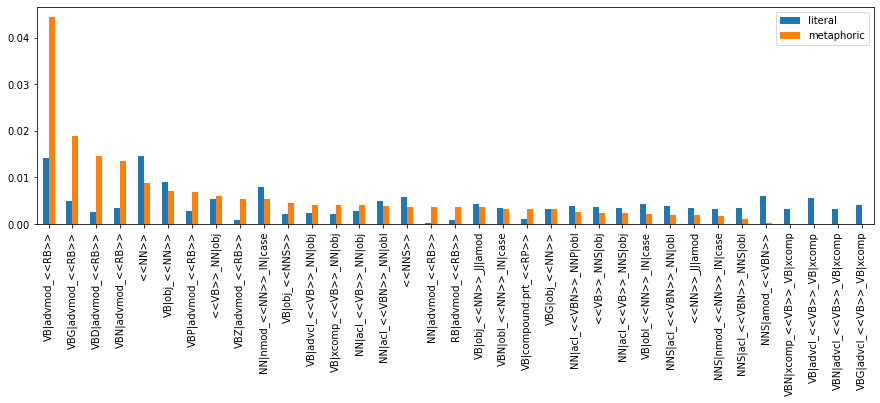

In [23]:
df_plot = pd.DataFrame.from_dict(c_both, orient="index")
# make columns to percentages
df_plot = df_plot.div(df_plot.sum(axis=0), axis=1)
# sort df_plot by metaphoric column
df_plot=df_plot.sort_values(by="metaphoric", ascending=False)
cutoff=0.003
df_plot = df_plot[(df_plot['literal'] >= cutoff) |(df_plot['metaphoric'] >= cutoff)]
plt.rcParams["figure.figsize"] = (15,4)
df_plot.plot(kind="bar")

In [24]:
df_all_annotated[df_all_annotated["STANZA_POS_DEPS"]=="VBG|advmod_<<RB>>"]

,Unnamed: 0,ID,SEED_WORD,SEED_WORD_IN_ORIGINAL,SEED_WORD_POS,ORIGINAL_SENTENCE,LEMMATIZED_SENTENCE,POS_TAGGED_SENTENCE,Metaphoric_All,Metaphoric_Seed,TAG,CTAG,DEPENDENCY_PARSE,CoreNLP_POS_DEPS,CoreNLP_WORD_DEPS,UPOS,XPOS,STANZA,STANZA_POS_DEPS,STANZA_WORD_DEPS
12216,10,551958ba-d623-11ec-b0f3-acde48001122,back,back,nn1_rp,"But just six days later , Jenn found herself d...",but just six day later jenn find herself drive...,"But_ccb just_rr six_mc days_nnt2 later_rrr ,_,...","['literal', 'literal', 'literal', 'literal', '...",metaphoric,RB,RB,"{1: {'address': 1, 'word': 'But', 'lemma': 'bu...",VBG|advmod_<<RB>>_NN|obl,driving|advmod_<<back>>_hospital|obl,ADV,RB,"[{'id': 1, 'text': 'But', 'lemma': 'but', 'upo...",VBG|advmod_<<RB>>,driving|advmod_<<back>>
12217,11,551969b8-d623-11ec-b0f3-acde48001122,back,back,rp,"Instead , the couple communicated via phone --...",instead the couple communicate via phone some ...,"Instead_rr ,_, the_at couple_nn1 communicated_...","['literal', 'literal', 'literal', 'literal', '...",metaphoric,RB,RB,"{1: {'address': 1, 'word': 'Instead', 'lemma':...",VBG|advmod_<<RB>>_IN|case,looking|advmod_<<back>>_on|case,ADV,RB,"[{'id': 1, 'text': 'Instead', 'lemma': 'instea...",VBG|advmod_<<RB>>,looking|advmod_<<back>>
12219,13,5519c322-d623-11ec-b0f3-acde48001122,back,back,rp,Bill Beaumont has been re-elected as the chair...,bill beaumont have be re-elect as the chairman...,Bill_np1 Beaumont_np1 has_vhz been_vbn re-elec...,"['literal', 'literal', 'literal', 'literal', '...",metaphoric,RB,RB,"{1: {'address': 1, 'word': 'Bill', 'lemma': 'B...",VBG|advmod_<<RB>>,beating|advmod_<<back>>,ADV,RB,"[{'id': 1, 'text': 'Bill', 'lemma': 'Bill', 'u...",VBG|advmod_<<RB>>,beating|advmod_<<back>>
12227,21,551bb1fa-d623-11ec-b0f3-acde48001122,back,back,nn1_rp,The defender is currently on loan at Estudiant...,the defender be currently on loan at estudiant...,The_at defender_nn1 is_vbz currently_rr on_ii ...,"['literal', 'literal', 'literal', 'literal', '...",metaphoric,RB,RB,"{1: {'address': 1, 'word': 'The', 'lemma': 'th...",VBG|advmod_<<RB>>,playing|advmod_<<back>>,ADV,RB,"[{'id': 1, 'text': 'The', 'lemma': 'the', 'upo...",VBG|advmod_<<RB>>,playing|advmod_<<back>>
12266,60,55342a14-d623-11ec-b0f3-acde48001122,back,back,rp_nn1,Unsolved Mysteries ran for over a decade -- of...,unsolved mystery run for over a decade often d...,Unsolved_jj Mysteries_nn2 ran_vvd for_if over_...,"['metaphoric', 'literal', 'metaphoric', 'liter...",metaphoric,RB,RB,"{1: {'address': 1, 'word': 'Unsolved', 'lemma'...",VBG|advmod_<<RB>>_NN|obl,dipping|advmod_<<back>>_library|obl,ADV,RB,"[{'id': 1, 'text': 'Unsolved', 'lemma': 'Unsol...",VBG|advmod_<<RB>>,dipping|advmod_<<back>>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14295,2089,599d09d6-d623-11ec-b0f3-acde48001122,back,back,rp,"Anthony Fauci , the director of the National I...",anthony fauci the director of the national ins...,"Anthony_np1 Fauci_np1 ,_, the_at director_nn1 ...","['literal', 'literal', 'literal', 'literal', '...",metaphoric,RB,RB,"{1: {'address': 1, 'word': 'Anthony', 'lemma':...",VBG|advmod_<<RB>>_NN|obl,dating|advmod_<<back>>_presidency|obl,ADV,RB,"[{'id': 1, 'text': 'Anthony', 'lemma': 'Anthon...",VBG|advmod_<<RB>>,dating|advmod_<<back>>
14305,2099,59a300ca-d623-11ec-b0f3-acde48001122,back,back,rp,""" I am so grateful for all the help I have had...",i be so grateful for all the help i have have ...,"""_"" I_ppis1 am_vbm so_rg grateful_jj for_if al...","['literal', 'literal', 'literal', 'literal', '...",metaphoric,RB,RB,"{1: {'address': 1, 'word': '""', 'lemma': '""', ...",VBG|advmod_<<RB>>_NN|obl,getting|advmod_<<back>>_rehab|obl,ADV,RB,"[{'id': 1, 'text': '""', 'lemma': '""', 'upos': ...",VBG|advmod_<<RB>>,getting|advmod_<<back>>
14318,2112,59a5c7ec-d623-11ec-b0f3-acde48001122,back,back,rp,"Quotable : "" It takes very little power to bre...",quotable it take very little power to break a ...,"Quotable_np1@_jj :_: ""_"" It_pph1 takes_vvz ver

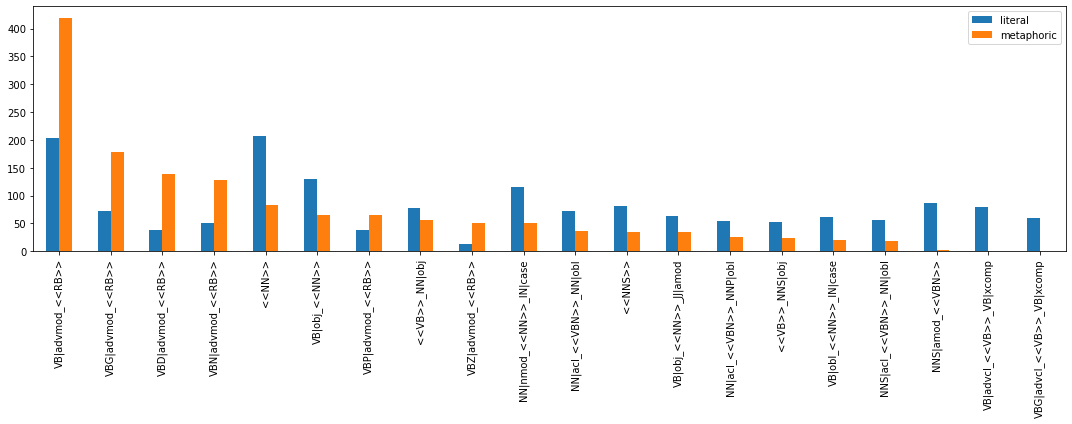

In [25]:
df_plot = pd.DataFrame.from_dict(c_both, orient="index")
df_plot=df_plot.sort_values(by="metaphoric", ascending=False)
cutoff=50
df_plot = df_plot[(df_plot['literal'] >= cutoff) |(df_plot['metaphoric'] >= cutoff)]
#fig = plt.figure(figsize=(10,4)) # Create matplotlib figure
plt.rcParams["figure.figsize"] = (15,6)
df_plot.plot(kind="bar")
plt.tight_layout()
plt.savefig("dep_stats_full.png")


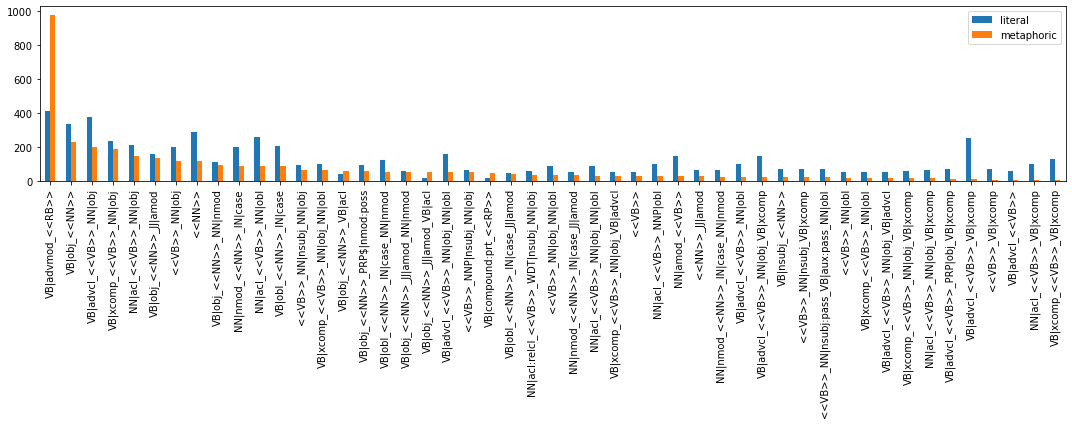

In [26]:
# with renamed values for plotting

# make copy of df_all_annotated
df_all_annotated_merged=df_all_annotated.copy()
# rename values in STANZA_POS_DEPS column (VBZ and VBN to VB)
df_all_annotated_merged["STANZA_POS_DEPS"]=df_all_annotated_merged["STANZA_POS_DEPS"].replace({"VBZ":"VB", "VBN":"VB", "VBG":"VB", "VBD":"VB", "VBP":"VB", "NNS":"NN"}, regex=True)
dep_res_l=list(df_all_annotated_merged[df_all_annotated_merged["Metaphoric_Seed"]=="literal"]["STANZA_POS_DEPS"])
c_l=Counter(dep_res_l)
dep_res_m=list(df_all_annotated_merged[df_all_annotated_merged["Metaphoric_Seed"]=="metaphoric"]["STANZA_POS_DEPS"])
c_m=Counter(dep_res_m)

# merge for plotting lib
c_both={}
all_keys=set(c_m.keys()).union(set(c_l.keys()))
for k in all_keys:
    c_both[k]={"literal":0, "metaphoric":0}
    if k in c_m:
        c_both[k]["metaphoric"]=c_m[k]
    if k in c_l:
        c_both[k]["literal"]=c_l[k]

df_plot = pd.DataFrame.from_dict(c_both, orient="index")
df_plot=df_plot.sort_values(by="metaphoric", ascending=False)
cutoff=50
df_plot = df_plot[(df_plot['literal'] >= cutoff) |(df_plot['metaphoric'] >= cutoff)]
#fig = plt.figure(figsize=(10,4)) # Create matplotlib figure
plt.rcParams["figure.figsize"] = (15,6)
df_plot.plot(kind="bar")
plt.tight_layout()
plt.savefig("dep_stats_merged.png")


In [27]:
# count metaphoric dependency constructions per seed-word (max 1 per seed-word)

dep_res_dict={}
dep_res_dict_count={}
# add all possible stanza_pos_deps to dep_res_dict
for k in df_all_annotated_merged["STANZA_POS_DEPS"].unique():
    dep_res_dict[k]=[]
    dep_res_dict_count[k]=0
# count
groups=df_all_annotated_merged[df_all_annotated_merged["Metaphoric_Seed"]=="metaphoric"].groupby("SEED_WORD")
for g in groups:
    for k in g[1]["STANZA_POS_DEPS"].unique():
        dep_res_dict[k].append(g[0])
        dep_res_dict_count[k]+=1

In [59]:
dep_res_dict

{'NN|nmod_<<NN>>_IN|case': ['aid',
  'back',
  'backup',
  'base',
  'bear',
  'bracket',
  'help',
  'hold',
  'keep',
  'living',
  'resource',
  'stand',
  'step',
  'support'],
 'NN|nmod_<<NN>>_IN|case_JJ|amod_NNP|appos_NNP|nmod': [],
 'NN|nmod_<<NN>>_IN|case_JJ|amod_JJ|amod': ['backing', 'resource', 'step'],
 '<<NN>>': ['back', 'base', 'bear', 'boost', 'resource', 'step', 'support'],
 'VB|nsubj_<<NN>>_JJ|amod_VB|acl:relcl': ['resource', 'step'],
 '<<NN>>_NNP|nsubj_VB|cop_JJ|amod_VB|acl:relcl': [],
 'VB|nsubj_<<NNP>>_NN|appos': [],
 'VB|obl_<<NN>>_IN|case_PRP$|nmod:poss_NN|nmod': ['stand', 'support'],
 'NN|nmod_<<NN>>_IN|case_JJ|amod_NN|nmod': ['back',
  'backing',
  'resource',
  'step',
  'support'],
 'NN|nmod_<<NN>>_IN|case_JJ|amod_NNP|nmod': ['resource', 'support'],
 'NN|nmod_<<NN>>_IN|case_NN|nmod': ['back',
  'bear',
  'maintenance',
  'resource',
  'stand',
  'step',
  'support'],
 'VB|nsubj_<<NN>>': ['back', 'hold', 'resource', 'step', 'support'],
 'VB|nsubj_<<NN>>_JJ|amod'

In [56]:
# write 3 samples per seed word per dependency construction to file
with open("dependency_patters_examples_metaphoric.txt", "w") as f:
    for k in dep_res_dict.keys():
        f.write("Pattern: "+k+"\n")
        for i in range(len(dep_res_dict[k])):
            # get 3 STANZA_WORD_DEPS examples per seed word from df_all_annotated_merged
            max_samples=len(df_all_annotated_merged[(df_all_annotated_merged["SEED_WORD"]==dep_res_dict[k][i]) & (df_all_annotated_merged["Metaphoric_Seed"]=="metaphoric") & (df_all_annotated_merged["STANZA_POS_DEPS"]==k)][["STANZA_WORD_DEPS", "ORIGINAL_SENTENCE"]])
            samples=df_all_annotated_merged[(df_all_annotated_merged["SEED_WORD"]==dep_res_dict[k][i]) & (df_all_annotated_merged["Metaphoric_Seed"]=="metaphoric") & (df_all_annotated_merged["STANZA_POS_DEPS"]==k)][["STANZA_WORD_DEPS", "ORIGINAL_SENTENCE"]].sample(min(3, max_samples))
            #print(samples)
            # iterate over samples and write to file
            for s in samples.itertuples():
                f.write("   Words: "+s.STANZA_WORD_DEPS+"\n")
                f.write("   Sentence: "+s.ORIGINAL_SENTENCE+"\n")
            f.write("\n")

45


<AxesSubplot:>

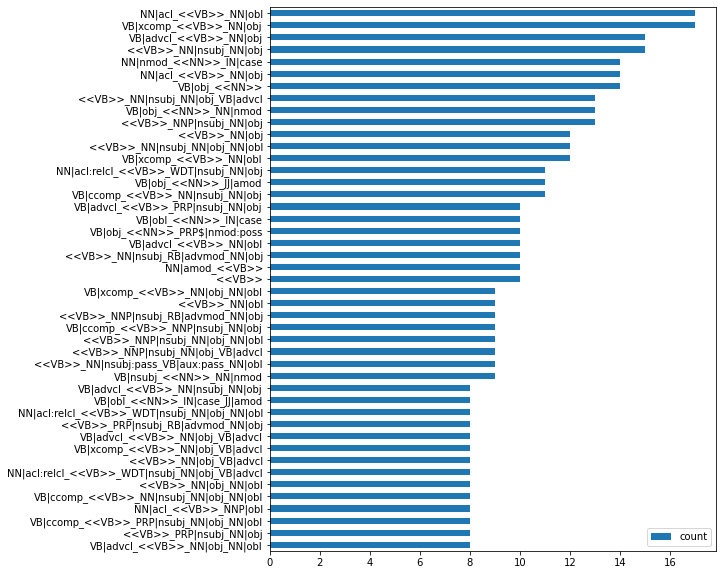

In [28]:
# plot bar chart of dep_res_dict_count
df_plot = pd.DataFrame.from_dict(dep_res_dict_count, orient="index", columns=["count"])
df_plot=df_plot[df_plot["count"]>7].sort_values(by="count", ascending=True)
plt.rcParams["figure.figsize"] = (8,10)
print(len(df_plot))
# plot bar chart horizontal
df_plot.plot(kind="barh")


133


,Pattern,count
531,VB|obj_<<NN>>_JJ|amod_NN|nmod,7
533,VB|obl_<<NN>>_IN|case_NN|nmod,7
535,NN|nmod_<<NN>>_IN|case_NN|nmod,7
536,<<NN>>,7
541,<<NN>>_NN|nmod,7
550,VB|obl_<<NN>>_IN|case_JJ|amod,8
557,VB|nsubj_<<NN>>_NN|nmod,9
566,VB|obl_<<NN>>_IN|case,10
568,VB|obj_<<NN>>_PRP$|nmod:poss,10
572,VB|obj_<<NN>>_JJ|amod,11


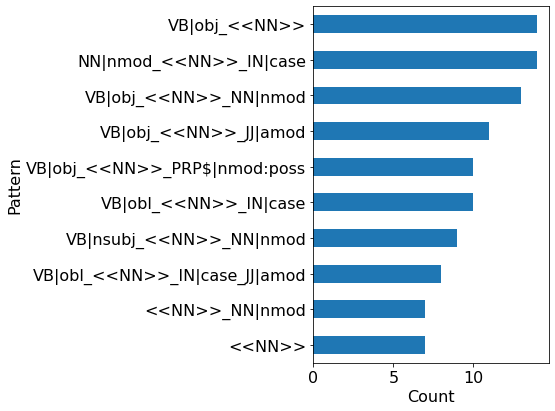

In [58]:
# plot bar chart of dep_res_dict_count
df_plot = pd.DataFrame.from_dict(dep_res_dict_count, orient="index", columns=["count"])
df_plot=df_plot[df_plot["count"]>1].sort_values(by="count", ascending=True).reset_index()
df_plot=df_plot[df_plot["index"].str.contains("<<NN>>")]
plt.rcParams["figure.figsize"] = (8,6)
print(len(df_plot))
# df plot rename index column to Pattern
df_plot.rename(columns={"index":"Pattern"}, inplace=True)
# plot bar chart horizontal
df_plot[-10:].plot(kind="barh", x="Pattern", y="count")
# increase font size of plot
plt.rcParams.update({'font.size': 16})
# plot remove legend
plt.legend().remove()
# plot add x-label
plt.xlabel("Count")
# save plot
plt.tight_layout()
plt.savefig("dep_stats_Nouns.png")
df_plot[-13:]



450


,Pattern,count
575,VB|xcomp_<<VB>>_NN|obl,12
576,<<VB>>_NN|nsubj_NN|obj_NN|obl,12
577,<<VB>>_NN|obj,12
579,<<VB>>_NN|nsubj_NN|obj_VB|advcl,13
580,<<VB>>_NNP|nsubj_NN|obj,13
582,NN|acl_<<VB>>_NN|obj,14
584,VB|advcl_<<VB>>_NN|obj,15
585,<<VB>>_NN|nsubj_NN|obj,15
586,VB|xcomp_<<VB>>_NN|obj,17
587,NN|acl_<<VB>>_NN|obl,17


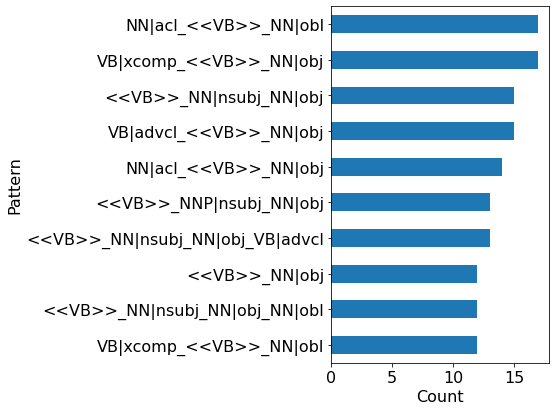

In [30]:
# plot bar chart of dep_res_dict_count
df_plot = pd.DataFrame.from_dict(dep_res_dict_count, orient="index", columns=["count"])
df_plot=df_plot[df_plot["count"]>1].sort_values(by="count", ascending=True).reset_index()
df_plot=df_plot[df_plot["index"].str.contains("<<VB>>")]
plt.rcParams["figure.figsize"] = (8,6)
print(len(df_plot))
df_plot.rename(columns={"index":"Pattern"}, inplace=True)
# plot bar chart horizontal
df_plot[-10:].plot(kind="barh", x="Pattern", y="count")
# increase font size of plot
plt.rcParams.update({'font.size': 16})
# plot remove legend
plt.legend().remove()
# plot add x-label
plt.xlabel("Count")
plt.tight_layout()
plt.savefig("dep_stats_Verbs.png")
df_plot[-10:]


179


,Pattern,count
1237,<<RB>>_NN|dislocated_NN|nsubj_VB|cop_RB|advmod,1
1238,VB|advmod_<<RB>>_CD|nummod,1
1239,VB|ccomp_<<RB>>_PRP|nsubj_RB|advmod_VB|cop_NNP...,1
1240,VB|ccomp_<<RB>>_VB|cop,1
1241,<<RB>>_NN|obl:tmod_PRP|nsubj_VB|cop_NN|obl,1
1242,NN|advmod_<<RB>>_NNPS|obl,1
1243,VB|ccomp_<<RB>>_NN|nsubj_VB|cop_NN|obl_JJ|advcl,1
1379,<<RB>>_PRP|nsubj_VB|cop_RB|advmod_NNP|obl_VB|a...,1
2702,NN|amod_<<JJ>>,3
2730,<<JJ>>,3


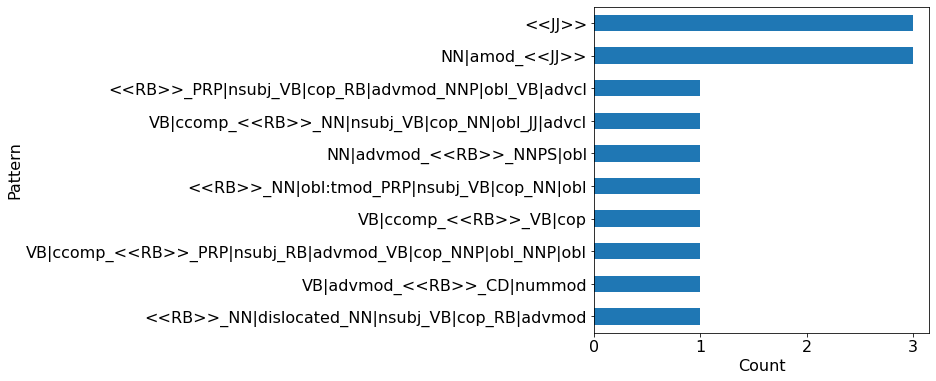

In [31]:
# plot bar chart of dep_res_dict_count
df_plot = pd.DataFrame.from_dict(dep_res_dict_count, orient="index", columns=["count"])
df_plot=df_plot[df_plot["count"]>0].sort_values(by="count", ascending=True).reset_index()
df_plot=df_plot[df_plot["index"].str.contains("<<JJ>>|<<RB>>|<<JJR>>|<<JJS>>|<<RBR>>|<<RBS>>")]
plt.rcParams["figure.figsize"] = (6,6)
print(len(df_plot))
df_plot.rename(columns={"index":"Pattern"}, inplace=True)
# plot bar chart horizontal
df_plot[-10:].plot(kind="barh", x="Pattern", y="count")
# increase font size of plot
plt.rcParams.update({'font.size': 16})
# plot remove legend
plt.legend().remove()
# plot add x-label
plt.xlabel("Count")
plt.tight_layout()
plt.savefig("dep_stats_Other.png")
df_plot[-10:]



## Metaphoric vs Literal usage

In [142]:
"supporting" in seed_words

True

In [143]:
# compute percentage of metaphoric usage for each seedword 
for seed_word in seed_words:
    value_counts=metaphor_annotated_dfs[seed_word]["Metaphoric_Seed"].value_counts()
    try:
        percentage_metaphoric_sw[seed_word]=value_counts["metaphoric"]/(value_counts["literal"]+value_counts["metaphoric"])*100
    except:
        percentage_metaphoric_sw[seed_word]=0.0

In [144]:
# statistics of one of the resulting dataframes
metaphor_annotated_dfs["support"]["Metaphoric_Seed"].value_counts()

metaphoric    1750
literal        567
Name: Metaphoric_Seed, dtype: int64

In [145]:
percentage_metaphoric_sw["support"]

75.52870090634441

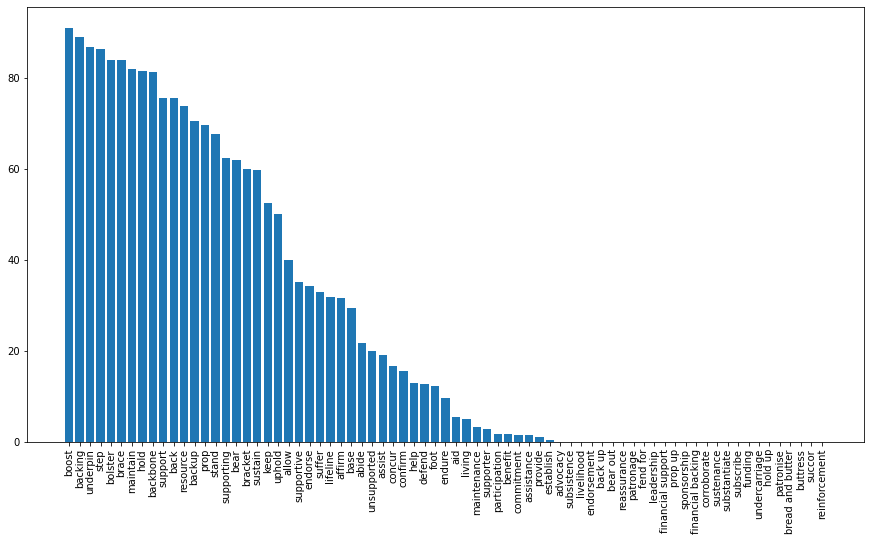

In [146]:
# plot percentages for all seed words
sorted_percentage_metaphoric_sw=dict(sorted(percentage_metaphoric_sw.items(), key=lambda item: item[1], reverse=True))
keys = sorted_percentage_metaphoric_sw.keys()
values = sorted_percentage_metaphoric_sw.values()

plt.bar(keys, values)
plt.rcParams["figure.figsize"] = (11,4)
plt.xticks(rotation=90);

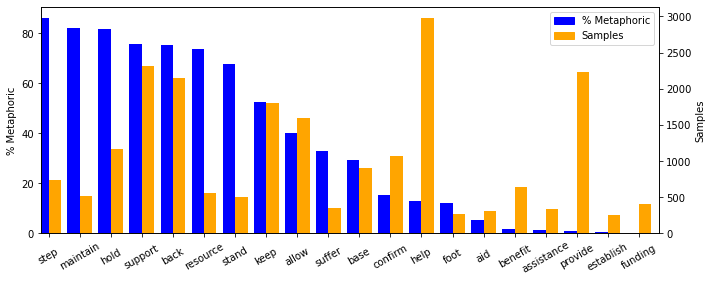

In [150]:
# compute frequencies for a grouped bar char
frequency = []
for k in sorted_percentage_metaphoric_sw: frequency.append(len(metaphor_annotated_dfs[k]))
labels = list(keys)
metaphoric_percentage = list(values)

fig = plt.figure(figsize=(10,4)) # Create matplotlib figure

# create df from which it is easy to plot
zipped = list(zip(labels, metaphoric_percentage, frequency))
df_for_plot = pd.DataFrame(zipped, columns=["Label",'Metaphoric', 'Frequency'])

df_for_plot = df_for_plot.loc[df_for_plot['Frequency'] >= 250]

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

colors = {'% Metaphoric':'blue', 'Samples':'orange'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax.legend(handles, labels)

width = 0.4

df_for_plot.Metaphoric.plot(kind='bar', color='blue', ax=ax, width=width, position=1)
df_for_plot.Frequency.plot(kind='bar', color='orange', ax=ax2, width=width, position=0)

ax.set_ylabel('% Metaphoric')
ax2.set_ylabel('Samples')

ax.set_xticklabels(labels=list(df_for_plot.Label),rotation=30, ha='center', va="center", position=(0,-0.07)); #ha="right"

plt.tight_layout()
fig.savefig("metaphor_stats.png")
plt.show()

In [148]:
len(metaphor_annotated_dfs["help"])

2985

# Clustering

## Cluster Support Sentences (mostly metaphoric)

Why "support"? Seed word with mostly metaphoric usage that has the most samples

In [ ]:
# define sentences that are being clustered
sentences_for_clustering = metaphor_annotated_dfs["support"]["ORIGINAL_SENTENCE"].tolist()

In [ ]:
len(sentences_for_clustering)

2322

In [ ]:
# load clustering model from BERTopic library and compute clusters
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True) 
topics, probs = topic_model.fit_transform(sentences_for_clustering)

Batches: 100%|██████████| 73/73 [01:19<00:00,  1.09s/it]
2022-05-08 11:34:57,966 - BERTopic - Transformed documents to Embeddings
2022-05-08 11:35:05,795 - BERTopic - Reduced dimensionality with UMAP
2022-05-08 11:35:06,008 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
# print the 5 clusters with most members. Topic -1 contains the outliers that usually should be ignored 
freq = topic_model.get_topic_info(); freq.head(5)

,Topic,Count,Name
0,-1,1034,-1_the_and_to_support
1,0,193,0_covid19_the_of_and
2,1,125,1_care_children_to_child
3,2,92,2_health_the_of_and
4,3,83,3_journalism_you_our_please


In [ ]:
topic_model.visualize_topics()

In [ ]:
# example topic
topic_model.get_topic(43) 

False

In [ ]:
topic_model.visualize_barchart(top_n_topics=5)

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

In [ ]:
# prepare clusters for saving in txt file
list_of_topics=[]
topic_names=list(topic_model.get_topic_info()["Name"])[1:]
for i in range(len(topic_model.get_topic_info())-1):
    list_of_topics.append(topic_model.get_representative_docs(i))  
# save list_of_topics to text file
with open("clusters_support.txt", "w") as f:
    for i in range(len(list_of_topics)):
        f.write(topic_names[i]+"\n")
        for j in list_of_topics[i]:
            f.write("---"+j+"\n")
        f.write("\n")
f.close()
        

In [ ]:
# find topics related to finance
similar_topics, similarity = topic_model.find_topics("journalism", top_n=5); similar_topics

[1, 17, 7, 27, 28]

In [ ]:
topic_model.get_topic(1)

[('journalism', 0.09721916678003913),
 ('you', 0.06894064070838037),
 ('please', 0.05475170391966732),
 ('local', 0.0515731381805162),
 ('consider', 0.049863571450366725),
 ('subscribing', 0.049553665305409195),
 ('our', 0.04779913544453664),
 ('press', 0.043492150366636596),
 ('news', 0.03861371383498026),
 ('subscribe', 0.03433260684853821)]

In [ ]:
topic_model.get_representative_docs(4)

['Third , society is showing its @ @ @ @ @ @ @ @ @ @ up digital platforms to raise funds , such as Covid-19 pandemic fund by MERCY and FV Covid-19 support fund . ',
 'A GoFundMe page that was opened Thursday to support his family showed Ernesto in a white suit at church . ',
 'PEOPLE has partnered with GoFundMe to raise money for the COVID-19 Relief Fund , a GoFundMe.org fundraiser to support everything from frontline responders to families in need @ @ @ @ @ @ @ @ @ @ information or to donate , click here . ']

Reduce Number of Clusters

In [ ]:
# after investigating the results we can also reduce the topics
new_topics, new_probs = topic_model.reduce_topics(sentences_for_clustering, topics, probs, nr_topics=15)

2022-04-18 23:30:30,227 - BERTopic - Reduced number of topics from 30 to 16


In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_barchart(top_n_topics=5)

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

## Cluster help (provide?) (mostly literal)

In [ ]:
# define sentences that are being clustered
sentences_for_clustering = metaphor_annotated_dfs["help"]["ORIGINAL_SENTENCE"].tolist()
len(sentences_for_clustering)

2988

In [ ]:
# load clustering model from BERTopic library and compute clusters
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True) 
topics, probs = topic_model.fit_transform(sentences_for_clustering)

Batches: 100%|██████████| 94/94 [01:34<00:00,  1.01s/it]
2022-05-08 11:44:26,906 - BERTopic - Transformed documents to Embeddings
2022-05-08 11:44:36,942 - BERTopic - Reduced dimensionality with UMAP
2022-05-08 11:44:37,265 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
# print the 5 clusters with most members. Topic -1 contains the outliers that usually should be ignored 
freq = topic_model.get_topic_info(); freq.head(5)

,Topic,Count,Name
0,-1,1546,-1_the_to_and_help
1,0,304,0_the_of_coronavirus_patients
2,1,98,1_we_it_us_to
3,2,70,2_journalism_us_news_our
4,3,55,3_masks_face_mask_wearing


In [ ]:
topic_model.visualize_hierarchy()

In [ ]:
topic_model.get_representative_docs(30)

['" Thai central bank seen cutting key rate to help economy in recession "',
 'Just over a third of Americans were aware the Federal Reserve cut interest rates on an emergency basis last week to help protect the U.S. economy from the uncertainty and risks generated by the coronavirus . ',
 'So in this context , lower interest rates will actually help to stabilize the housing market , rather than contribute to froth . ']

In [ ]:
# prepare clusters for saving in txt file
list_of_topics=[]
topic_names=list(topic_model.get_topic_info()["Name"])[1:]
for i in range(len(topic_model.get_topic_info())-1):
    list_of_topics.append(topic_model.get_representative_docs(i))  
# save list_of_topics to text file
with open("clusters_help.txt", "w") as f:
    for i in range(len(list_of_topics)):
        f.write(topic_names[i]+"\n")
        for j in list_of_topics[i]:
            f.write("---"+j+"\n")
        f.write("\n")
f.close()
        

In [ ]:
# find topics related to finance
similar_topics, similarity = topic_model.find_topics("journalism", top_n=5); similar_topics

[6, 27, 4, 23, 22]

In [ ]:
topic_model.get_representative_docs(4)

['" Serious shortages of staff meant that there was little , if any , time to provide support to residents in facilities where many died . "',
 '" Summerlin was created with a vision to provide a sense of community for all generations . "',
 '" We stand beside them during these unprecedented times and will continue to do our best to provide valuable help to the selfless heroes that are saving lives and helping vulnerable people in communities throughout the country . "']

In [ ]:
# after investigating the results we can also reduce the topics
new_topics, new_probs = topic_model.reduce_topics(sentences_for_clustering, topics, probs, nr_topics=15)

2022-04-19 02:07:20,912 - BERTopic - Reduced number of topics from 37 to 16


In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

## Cluster hold

In [180]:
# define sentences that are being clustered
sentences_for_clustering = metaphor_annotated_dfs["hold"]["ORIGINAL_SENTENCE"].tolist()
len(sentences_for_clustering)

1169

In [181]:
# load clustering model from BERTopic library and compute clusters
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True) 
topics, probs = topic_model.fit_transform(sentences_for_clustering)

Batches:   0%|          | 0/37 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Batches: 100%|██████████| 37/37 [00:35<00:00,  1.04it/s]
2022-05-18 19:14:39,051 - BERTopic - Transformed documents to Embeddings
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2022-05-18 19:14:44,761 - BERTopic - Reduced dimensionality with UMAP
2022-05-18 19:14:44,852 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [182]:
# print the 5 clusters with most members. Topic -1 contains the outliers that usually should be ignored 
freq = topic_model.get_topic_info(); freq.head(5)

,Topic,Count,Name
0,-1,332,-1_the_to_in_and
1,0,213,0_the_to_of_in
2,1,169,1_the_of_in_hold
3,2,80,2_we_hold_you_and
4,3,65,3_school_classes_will_the


In [183]:
topic_model.visualize_topics()

In [184]:
topic_model.visualize_hierarchy(top_n_topics=50)

In [185]:
# prepare clusters for saving in txt file
list_of_topics=[]
topic_names=list(topic_model.get_topic_info()["Name"])[1:]
for i in range(len(topic_model.get_topic_info())-1):
    list_of_topics.append(topic_model.get_representative_docs(i))  
# save list_of_topics to text file
with open("clusters_hold.txt", "w") as f:
    for i in range(len(list_of_topics)):
        f.write(topic_names[i]+"\n")
        for j in list_of_topics[i]:
            f.write("---"+j+"\n")
        f.write("\n")
f.close()
        

In [186]:
# find topics related to finance
similar_topics, similarity = topic_model.find_topics("journalism", top_n=5); similar_topics

[7, 6, 3, 13, 10]

In [187]:
# after investigating the results we can also reduce the topics
new_topics, new_probs = topic_model.reduce_topics(sentences_for_clustering, topics, probs, nr_topics=15)

2022-05-18 19:14:47,144 - BERTopic - Reduced number of topics from 15 to 15


In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)